In [1]:

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import temgymbasic.jax_components as comp
from temgymbasic.jax_run import run_to_component
from temgymbasic.jax_ray import Ray, propagate
from jax.scipy.interpolate import RegularGridInterpolator
import tqdm.auto as tqdm
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".01"
%matplotlib widget
jax.config.update("jax_platform_name", "cpu")

In [2]:
# Set up the function to calculate the jacobian after propagation from one component to another
# We can run multiple rays if we want, but no need for now. 
jac_run_to_component = jax.vmap(jax.jacobian(run_to_component), in_axes=(0, None))

@jax.jit
def run_model_for_jacobians(ray, model):

    model_jacobians = []

    # Get all jacobians from one component to another
    for i in range(1, len(model)):
        distance = (model[i-1].z - ray.z).squeeze()
        ray = propagate(distance, ray)
        ray = model[i-1].step(ray)
        
        jacobian = jac_run_to_component(ray, model[i])
        model_jacobians.append({
            'jacobian': jacobian
        })

    # Edit the jacobian matrices to include shifts calculated 
    # from the opl derivative
    each_ABCD = [] #ABCD matrices at each component
    total_ABCD = jnp.eye(5)

    for jacobian in model_jacobians:
        ray_jacobian = jacobian['jacobian'] #dr_out/dr_in
        shift_vectors = ray_jacobian.pathlength.matrix # This is the shift vector for each ray, dopl_out/dr_in
        ABCD = ray_jacobian.matrix.matrix # This is the ABCD matrix for each ray, dr_out/dr_in
        ABCD = ABCD.at[0, :, -1].set(shift_vectors[0, :])
        ABCD = ABCD.at[0, -1, -1].set(1.0)
        each_ABCD.append(ABCD)
        total_ABCD = ABCD @ total_ABCD

    return model_jacobians, each_ABCD, total_ABCD, ray

@jax.jit
def run_model_for_rays_and_slopes(model, each_ABCD, input_slopes, scan_position):
    #Given input model and it's transfer matrix, run the model to find the positions of the rays at the sample and detector

    scan_pos_y, scan_pos_x = scan_position

    input_slopes_x = input_slopes[0]
    input_slopes_y = input_slopes[1]

    # Make the input rays we can run through one last time in the model to find positions at sample and detector
    rays_at_source_with_semi_conv = jnp.vstack([
        jnp.full(len(input_slopes_x), scan_pos_x),
        jnp.full(len(input_slopes_y), scan_pos_y),
        input_slopes_x,
        input_slopes_y,
        jnp.ones_like(input_slopes_x)
    ])

    # Propagate the point source coordinates through the forward ABCD matrices
    coord_list = [rays_at_source_with_semi_conv]
    for ABCD in each_ABCD:
        new_coord = jnp.dot(ABCD[0], coord_list[-1])
        coord_list.append(new_coord)
        
    # Stack the propagated coordinates into an array for easier indexing
    coords_array = jnp.stack(coord_list, axis=0)
    
    xs = coords_array[:, 0, :]
    ys = coords_array[:, 1, :]
    dxs = coords_array[:, 2, :]
    dys = coords_array[:, 3, :]
    zs = jnp.array([comp.z for comp in model])

    return xs, ys, zs, dxs, dys

@jax.jit
def find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(pixel_coords, scan_pos, semi_conv, transformation_matrix):
    """
    Given a set of detector pixel coordinates, a semi-convergence angle from a source, and a transformation matrix, find a mask that tells us 
    what slopes will hit the detector pixels from the point source.

    Args:
    - pixel_coords (jnp.array): A (N, 2) array of pixel coordinates in y, x format.
    - scan_pos (jnp.array): A (2,) array of the scan position in x and y format.
    - semi_conv (float): The semi-convergence angle of the point source.q
    - transformation_matrix (jnp.array): A (5, 5) transformation matrix.
    """
    # We rely on the fact that theta_x_in**2 + theta_y_in**2 = semi_conv**2 - this is essentially a parametric equation of an ellipse.  
    # which can be evaluated to find all pixels less than any semi_conv from the point source 
    # For a point source, our system of equations is:
    # [x_out, y_out, theta_x_out, theta_y_out, 1] = transformation_matrix @ [scan_pos_x, scan_pos_y, theta_x_in, theta_y_in, 1]
    # where theta_x_in and theta_y_in are given by alpha * cos(phi) and alpha * sin(phi), with alpha being the semi convergence angle
    # and phi the azimuthal angle of a ray from the point source. This is a parametric equation for a cone of rays from the point source
    # giving us the means to find a mask, which will tell us which slopes will hit the detector pixel from the point source for a given semi_conv.
    scan_pos_y, scan_pos_x = scan_pos
    A_xx, A_xy, B_xx, B_xy = transformation_matrix[0, :4] # Select first row not including the last column of values from the 5x5 transfer matrix
    A_yx, A_yy, B_yx, B_yy = transformation_matrix[1, :4] # Select second row not including the last column of values from the 5x5 transfer matrix
    delta_x, delta_y = transformation_matrix[0, 4], transformation_matrix[1, 4] # Get the shift values from the final column of the transfer matrix
    y_out, x_out = pixel_coords[:, 0], pixel_coords[:, 1]

    denom = (B_xx*B_yy - B_xy*B_yx)
    theta_x_in = (-A_xx*B_yy*scan_pos_x - A_xy*B_yy*scan_pos_y + A_yx*B_xy*scan_pos_x + 
         A_yy*B_xy*scan_pos_y + B_xy*delta_y - B_xy*y_out - B_yy*delta_x + B_yy*x_out) / denom
    theta_y_in = (A_xx*B_yx*scan_pos_x + A_xy*B_yx*scan_pos_y - A_yx*B_xx*scan_pos_x - 
         A_yy*B_xx*scan_pos_y - B_xx*delta_y + B_xx*y_out + B_yx*delta_x - B_yx*x_out) / denom
    F = (theta_x_in**2 + theta_y_in**2) - semi_conv **2
    mask = F <= 0
    input_slopes_x_masked = jnp.where(mask, theta_x_in, 0.0)
    input_slopes_y_masked = jnp.where(mask, theta_y_in, 0.0)
    input_slopes_masked = jnp.stack([input_slopes_x_masked, input_slopes_y_masked])
    
    return input_slopes_masked, mask


@jax.jit
def map_px_on_detector_to_sample(sample_image, detector_image,
                                 sample_pixel_size, det_pixel_size,
                                 ray_sample_coords_x, ray_sample_coords_y,
                                 ray_det_coords_x, ray_det_coords_y):
    """
    Map the pixel intensities from the detector image back onto the sample image.
    For each detector image from a scan position, we back propagate this image to the input sample coordinates.
    By adding each image together on the sample, we can create a "shifted sum" image. 

    Args:
      sample_image (jnp.array): The accumulation image on the sample (2D array).
      detector_image (jnp.array): The image measured on the detector (2D array).
      sample_pixel_size (float): Pixel size of the sample image.
      det_pixel_size (float): Pixel size of the detector image.
      ray_sample_coords_x (jnp.array): 1D array of ray x coordinates on the sample (in physical units).
      ray_sample_coords_y (jnp.array): 1D array of ray y coordinates on the sample (in physical units).
      ray_det_coords_x (jnp.array): 1D array of ray x coordinates on the detector (in physical units).
      ray_det_coords_y (jnp.array): 1D array of ray y coordinates on the detector (in physical units).

    Returns:
      jnp.array: The updated sample image with detector intensities added accordingly.
    """
    sample_shape = sample_image.shape
    det_shape = detector_image.shape

    # Convert ray coordinates to pixel indices in the sample image.
    sample_pixel_xs = ray_sample_coords_x / sample_pixel_size + sample_shape[1] / 2
    sample_pixel_ys = ray_sample_coords_y / sample_pixel_size + sample_shape[0] / 2
    sample_pixel_xs = jnp.round(sample_pixel_xs).astype(jnp.int32)
    sample_pixel_ys = jnp.round(sample_pixel_ys).astype(jnp.int32)

    # Convert ray coordinates to pixel indices in the detector image.
    det_pixel_xs = ray_det_coords_x / det_pixel_size + det_shape[1] / 2
    det_pixel_ys = ray_det_coords_y / det_pixel_size + det_shape[0] / 2
    det_pixel_xs = jnp.round(det_pixel_xs).astype(jnp.int32)
    det_pixel_ys = jnp.round(det_pixel_ys).astype(jnp.int32)

    # Gather the detector pixel intensities
    detector_vals = detector_image[(det_pixel_ys, det_pixel_xs)]

    # Continuously add the detector contributions to the sample image.
    sample_image_updated = sample_image.at[(sample_pixel_ys, sample_pixel_xs)].add(detector_vals)

    return sample_image_updated


@jax.jit
def get_shifted_sum(model, fourdstem_array, sample_image, semi_conv, scan_px_size):
    InputPlane = model[0]
    Sample = model[1]
    Descanner = model[2]
    Rotator = model[3]
    Detector = model[4]

    sample_coords = Sample.get_coords().reshape(sample_image.shape[0], sample_image.shape[1], 2)
    detector_coords_yx = Detector.get_coords()
    descan_error = Descanner.descan_error
    det_px_size = Detector.pixel_size
    
    def inner_loop(scan_idx_x, sample_image_inner, scan_idx_y):
        scan_pos = sample_coords[scan_idx_y, scan_idx_x]
        input_ray_positions = jnp.array([[scan_pos[1], scan_pos[0], 0.0, 0.0, 1.0]])

        ray = Ray(z=InputPlane.z, 
                  matrix=input_ray_positions, 
                  amplitude=jnp.ones(1), 
                  pathlength=jnp.zeros(1), 
                  wavelength=jnp.ones(1),
                  blocked=jnp.zeros(1, dtype=float))
        
        new_Descanner = comp.Descanner(z=Sample.z,
                                       descan_error=descan_error,
                                       offset_x=scan_pos[1],
                                       offset_y=scan_pos[0])
        
        model = [InputPlane, Sample, new_Descanner, Rotator, Detector]

        _, each_ABCD, total_ABCD, _ = run_model_for_jacobians(ray, model)
        
        sample_to_detector = each_ABCD[3] @ each_ABCD[2] @ each_ABCD[1]
        detector_to_sample = jnp.linalg.inv(sample_to_detector)

        input_slopes, _ = find_input_slopes_that_hit_detpx_from_pt_source_with_semiconv(
                                detector_coords_yx, scan_pos, semi_conv, total_ABCD[0])
        
        xs, ys, _, dxs, dys = run_model_for_rays_and_slopes(model, each_ABCD, input_slopes, scan_pos)
        detector_rays = jnp.stack([xs[-1], ys[-1], dxs[-1], dys[-1], jnp.ones_like(xs[-1])])
        sample_rays = jnp.dot(detector_to_sample[0], detector_rays)
        
        sample_rays_x = sample_rays[0]
        sample_rays_y = sample_rays[1]

        det_rays_x = detector_rays[0]
        det_rays_y = detector_rays[1]

        det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]

        sample_image_updated = map_px_on_detector_to_sample(sample_image_inner, det_image_selected,
                                                            scan_px_size, det_px_size,
                                                            sample_rays_x, sample_rays_y,
                                                            det_rays_x, det_rays_y)
        return sample_image_updated

    def outer_loop(scan_idx_y, sample_image_inner):
        def inner_body(scan_idx_x, sample_image_acc):
            return inner_loop(scan_idx_x, sample_image_acc, scan_idx_y)
        return jax.lax.fori_loop(0, sample_coords.shape[1], inner_body, sample_image_inner)
    
    return jax.lax.fori_loop(0, sample_coords.shape[0], outer_loop, sample_image)



In [3]:
data = np.load('fourdstem_overfocused.npy')
from scipy.ndimage import zoom

sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape


sample_image = jnp.array(sample_image, dtype=jnp.complex64)


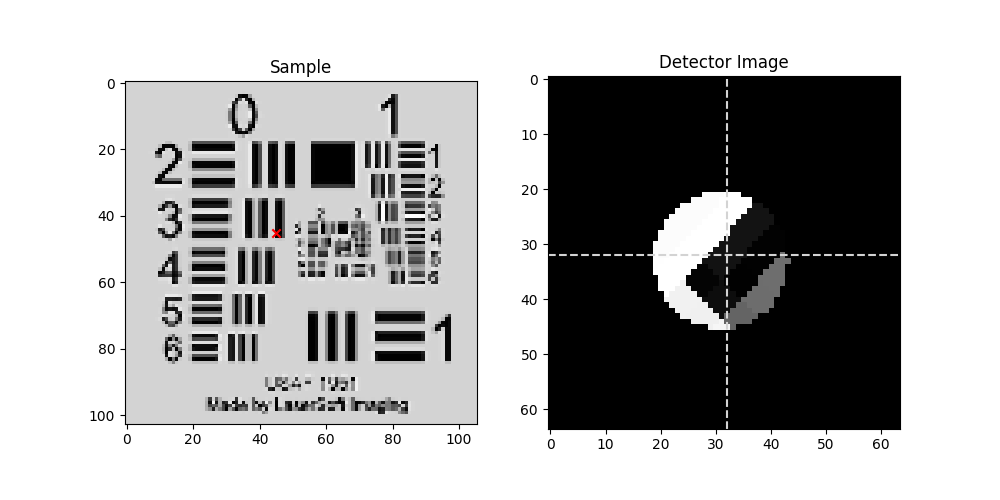

In [4]:
scan_idx_x, scan_idx_y = 45, 45
det_image_selected = data[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(sample_image), 
             cmap='gray')
ax[0].scatter(scan_idx_x, scan_idx_y, c='r', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(det_image_selected.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(det_image_selected.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

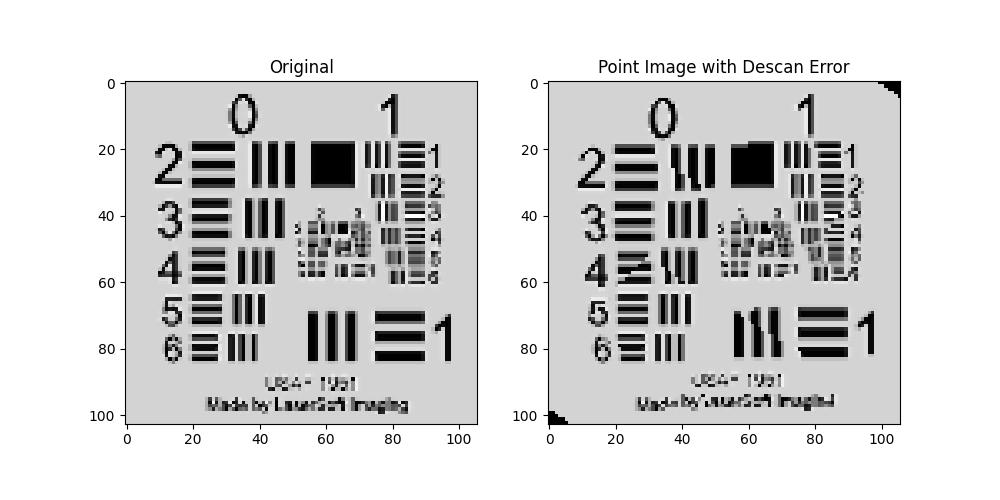

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title('Original')
axes[0].imshow(np.abs(sample_image), cmap='gray')
axes[1].set_title('Point Image with Descan Error')
axes[1].imshow(np.abs(data[:, :, det_image_selected.shape[0]//2, det_image_selected.shape[1]//2]), cmap='gray')

In [10]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 
Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

defocus = 0.01
semi_conv = 0.025
camera_length = 1.0
scan_size = sample_image_shape
det_size = (64, 64)
scan_px_size = 0.0001
det_px_size= 0.002
rotation = 45

#Create ray input z plane
crossover_z = jnp.zeros((1))

In [11]:
InputPlane = comp.InputPlane(z=crossover_z)
Sample = comp.Sample(z=jnp.array([defocus]), complex_image=sample_image, pixel_size=scan_px_size)
Descanner = comp.Descanner(z=jnp.array([defocus]), descan_error=descan_error, offset_x=0.0, offset_y=0.0)
Rotator = comp.Rotator(z=jnp.array([defocus]), angle=rotation)
Detector = comp.Detector(z=jnp.array([camera_length]), shape=det_size, pixel_size=det_px_size)
model = [InputPlane, Sample, Descanner, Rotator, Detector]

sample_image = jnp.zeros_like(sample_image, dtype=jnp.complex64)

In [12]:
sample_image = get_shifted_sum(model, data, sample_image, semi_conv, scan_px_size)

Text(0.5, 1.0, 'Shifted Sum Image')

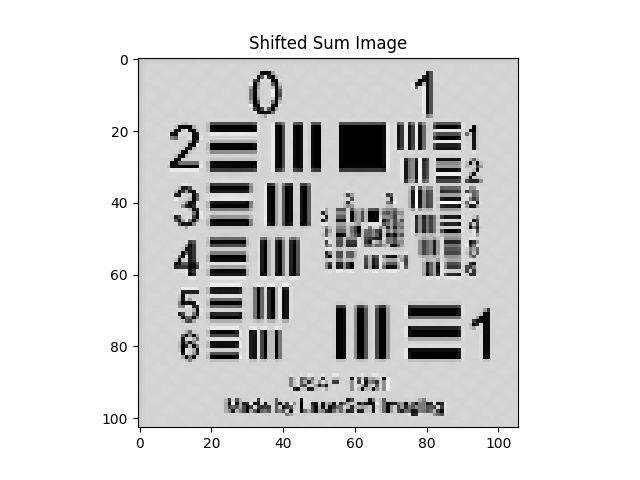

In [13]:
plt.figure()
plt.imshow(np.abs(sample_image), cmap='gray')
plt.title('Shifted Sum Image')